In [1]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
from collections import OrderedDict
%matplotlib inline

#local imports
from detection_rate_main import detection_rate_main, z_at
from utils.mergerrate import MergerRate
from utils.mbhbinaries import  mass_ratio_func
from utils.evolveFDFA import EvolveFDFA
from utils.basicmergers import MagicMergers, ConstantTime
from utils.parallelsnr import ParallelSNR

from pyphenomd.pyphenomd import *
from pyphenomd.read_noise_curves import read_noise_curve
import scipy.constants as ct
from scipy import stats
Msun=1.989e30

## Declare Resample Parameters

In [2]:
num_catalogs = 10
t_obs = 5.0 #years
duration = 100.0 #years

#input file
fp = 'simulation_input_data.txt'

##################
###### KDE #######
##################

# what key for the input data for m1, m2. It is not
# needed for z because we calculate z_coalescence. 
kde_key_guide = OrderedDict()
kde_key_guide['m1'] = 'mass_new_prev_in'
kde_key_guide['m2'] = 'mass_new_prev_out'
#kde_key_guide['z'] = 'redshift'

########################
###### Evolution #######
########################

# evolve with Dosopoulou and Antonini 2017
evolve_class = EvolveFDFA
# keys are the parameter names for the evolution scenario. 
# values are the corresponding names of the input_data columns
evolve_key_guide = {'m1':'mass_new_prev_in', 'm2':'mass_new_prev_out', 
                    'z':'redshift', 'separation':'separation', 'star_gamma':'star_gamma', 
                    'vel_disp_1':'vel_disp_prev_in',  'vel_disp_2':'vel_disp_prev_out'}


# magic mergers
#evolve_key_guide = {'z':'redshift'}
#evolve_class = MagicMergers

###########################
###### merger rate  #######
###########################

# kwargs related to merger rate calculation
merger_rate_kwargs = {'Vc':106.5**3, 'dz':0.001, 'zmax':10.0}

############################################
###### Parrallel Calculation of SNRs #######
############################################
parallel_kwargs = {'num_processors':None, 'num_splits':1000, 'verbose':50}


##########################
###### SNR Options #######
##########################
snr_kwargs = {'wd_noise':True, 'num_points':2048, 'sensitivity_curve':'LPA', 'prefactor':np.sqrt(16./5.)}

## Run the Resampler

In [20]:
data = np.genfromtxt('simulation_input_data.txt', names=True)

evolution_classes = [[EvolveFDFA, {'m1':'mass_new_prev_in', 'm2':'mass_new_prev_out', 
                    'z':'redshift', 'separation':'separation', 'star_gamma':'star_gamma', 
                    'vel_disp_1':'vel_disp_prev_in',  'vel_disp_2':'vel_disp_prev_out'}, 'FDFA'],
                     [ConstantTime, {'z':'redshift','m1':'mass_new_prev_in', 'm2':'mass_new_prev_out',}, 'Constant'],
                     [MagicMergers, {'z':'redshift','m1':'mass_new_prev_in', 'm2':'mass_new_prev_out',}, 'Magic Mergers']]

dz = 0.25
evolve_out = {}
for evolve_class, evolve_dict, label in evolution_classes:
    evolve_kwargs = {key:data[evolve_dict[key]] for key in evolve_dict.keys()}
    evolve = evolve_class(**evolve_kwargs)
    evolve.evolve()
    keep = (evolve.coalescence_time<cosmo.age(0.0).value*1e9) & (mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])>1e-4)
    z_coal = z_at(evolve.coalescence_time[keep])
    
    mr = MergerRate(z_coal, 106.5**3,dz=dz)
    zs, integrand, rate = mr.merger_rate(return_for_plot=True)
    
    snr_vals = (snr(evolve.m1[keep], evolve.m2[keep], np.full(len(evolve.m1,), 0.8),
                    np.full(len(evolve.m1,), 0.8), z_coal, 1.0, 0.0, sensitivity_curve='LPA'))
    mr_det = MergerRate(z_coal[snr_vals>8.0], 106.5**3,dz=dz)
    zs_det, integrand_det, rate_det = mr.merger_rate(return_for_plot=True)
    print(label, rate)
    
    cats_det = detection_rate_main(num_catalogs, t_obs, duration, fp,
                            evolve_dict, kde_key_guide, evolve_class,
                            merger_rate_kwargs, parallel_kwargs, snr_kwargs,
                            only_detectable=True, snr_threshold=8.0)
    evolve_out['data'] = {'m1': data['mass_new_prev_in'], 'm2': data['mass_new_prev_out'],
                          'mt': data['mass_new_prev_in'] + data['mass_new_prev_out'],
                          'mr': mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])}
    evolve_out[label] = {'cats_det':cats_det,
                         'merger_rate_info':{'zs':zs, 'integrand':integrand, 'rate': rate, 'integrand_det': integrand_det, 'zs_det': zs_det, 'rate_det': rate_det},
                         'coalesced': keep, 'timescale': evolve.coalescence_time}
    print(label, 'done')

/Users/michaelkatz/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in greater


FDFA 0.9162016140313249
merger rate: 0.835754845264479
numprocs 4
start pool with 4 processors: 1 total processes.

SNR calculation time: 0.6525671482086182
Total Duration: 30.34700608253479
FDFA done
Constant 0.8037480295883201
merger rate: 0.7183688240142857
numprocs 4
start pool with 4 processors: 1 total processes.

SNR calculation time: 0.5644490718841553
Total Duration: 18.322601795196533
Constant done
Magic Mergers 1.11666912528749
merger rate: 1.0342475773082238
numprocs 4
start pool with 4 processors: 2 total processes.

SNR calculation time: 0.7704741954803467
Total Duration: 17.10642099380493
Magic Mergers done


In [12]:
def merger_integrand(ax, detectable=False, label_fontsize=18, tick_fontsize=14, legend=True):
    snr_bins = np.linspace(np.log10(8.0), 5.0, 20)
    for label in evolve_out:
        if detectable:
            extra_string = '_det'
        else:
            extra_string = ''
        z, dN_dzdt = evolve_out[label]['merger_rate_info']['zs' + extra_string], -evolve_out[label]['merger_rate_info']['integrand' + extra_string]
        ax.plot(z, dN_dzdt, label=label)

    xticks = [0,2,4,6,8]
    ax.set_xlim(np.log10(8.0), max(xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%i'%i for i in xticks], fontsize=tick_fontsize)
    
    yticks = [0.0,0.1,0.2,0.3,0.4,0.5]
    #ax.set_ylim(min(xticks), max(xticks))
    #ax.set_yticks(xticks)
    #ax.set_yticklabels(['%i'%i for i in xticks], fontsize=14)

    ax.set_xlabel('Redshift',fontsize=label_fontsize)
    if detectable:
        ylabel = r'$\frac{dN\left(\rho>8\right)}{dzdt_{obs}}$'
    else:
        ylabel = r'$\frac{dN}{dzdt_{obs}}$'
    ax.set_ylabel(ylabel, rotation='horizontal', labelpad=40, fontsize=label_fontsize)
    if legend:
        ax.legend(loc='best')
    return ax

In [13]:
def snr_hist(ax, label_fontsize=18, tick_fontsize=14, legend=True):
    snr_bins = np.linspace(np.log10(8.0), 5.0, 20)
    for label in evolve_out:
        snr_label = evolve_out[label]['cats_det']['snr']
        ax.hist(np.log10(snr_label), bins=snr_bins, label=label, histtype='step', lw=1.5, log=True, density=True)

    xticks = [1,2,3,4,5]
    ax.set_xlim(np.log10(8.0), max(xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%i'%i for i in xticks], fontsize=tick_fontsize)
    
    #yticks = [0,1,2,3,4,5]
    #ax.set_ylim(min(xticks), max(xticks))
    #ax.set_yticks(xticks)
    #ax.set_yticklabels(['%i'%i for i in xticks], fontsize=14)
   

    ax.set_xlabel('Signal-to-Noise Ratio',fontsize=label_fontsize)
    ax.set_ylabel('Density', labelpad=20, fontsize=label_fontsize)
    if legend:
        ax.legend(loc='best')
    return ax

In [14]:
def detection_hist(ax, label_fontsize=18, tick_fontsize=14, legend=True):
    detection_bins = np.linspace(0.0, 5.0, 20)
    for label in evolve_out:
        uni_vals, uni_counts = np.unique(evolve_out[label]['cats_det']['cat'], return_counts=True)
        per_year_counts = uni_counts/t_obs
        print(label, 'mean detect counts', np.mean(per_year_counts))
        ax.hist(per_year_counts, bins=detection_bins, label=label, histtype='step', lw=1.5, log=True, density=True)

    xticks = [0,1,2,3,4,5]
    ax.set_xlim(0.0, max(xticks))
    ax.set_xticks(xticks)
    ax.set_xticklabels(['%i'%i for i in xticks], fontsize=tick_fontsize)
    
    #yticks = [0,1,2,3,4,5]
    #ax.set_ylim(min(xticks), max(xticks))
    #ax.set_yticks(xticks)
    #ax.set_yticklabels(['%i'%i for i in xticks], fontsize=14)
   

    ax.set_xlabel('Detection Count',fontsize=label_fontsize)
    ax.set_ylabel('Density', labelpad=20, fontsize=label_fontsize)
    if legend:
        ax.legend(loc='best')
    return ax

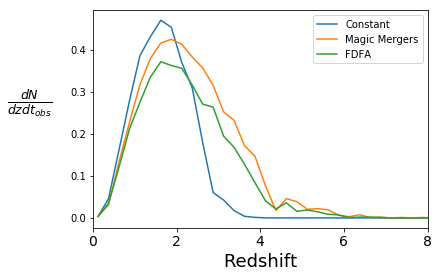

In [16]:
fig, ax = plt.subplots(1,1)
ax = merger_integrand(ax, detectable=False)

Magic Mergers mean detect counts 0.6399999999999999
FDFA mean detect counts 0.6444444444444444
Constant mean detect counts 0.38


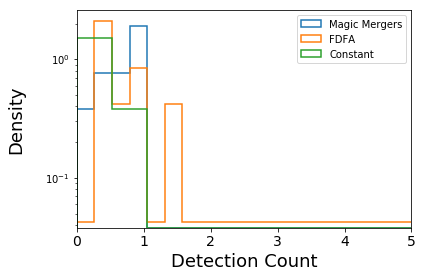

In [41]:
fig, ax = plt.subplots(1,1)
ax = detection_hist(ax)

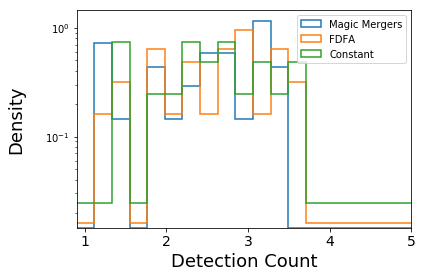

In [51]:
fig, ax = plt.subplots(1,1)
ax = snr_hist(ax)

Magic Mergers mean detect counts 0.6399999999999999
FDFA mean detect counts 0.6444444444444444
Constant mean detect counts 0.38


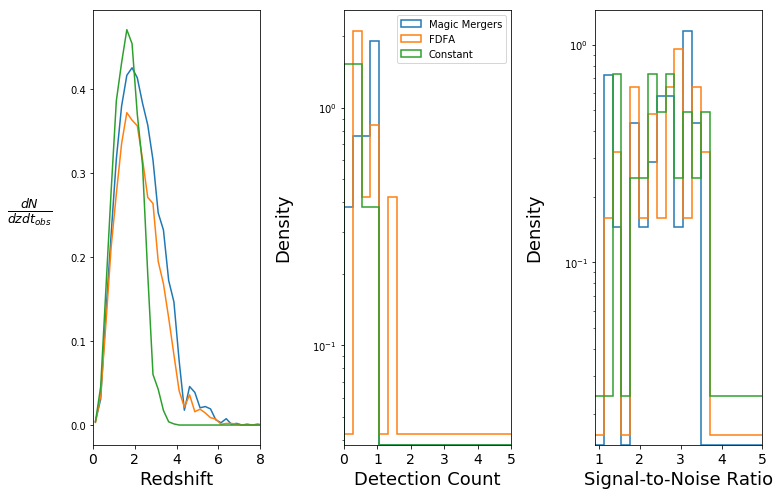

In [66]:
fig, ax = plt.subplots(1,3)
plt.subplots_adjust(wspace=0.5)
fig.set_size_inches(12,8)
ax = ax.ravel()
for i, func in enumerate([merger_integrand, detection_hist, snr_hist]):
    if i == 1:
        legend = True
    else:
        legend = False
    ax[i] = func(ax[i], legend=legend)

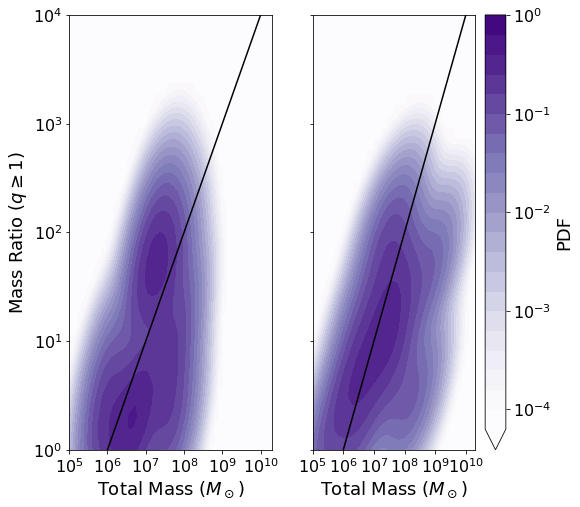

In [74]:
labels = ['FDFA', 'Constant']
f, ax = plt.subplots(1, len(labels), sharex=True, sharey=True)
try:
    ax = ax.ravel()
except AttributeError:
    ax = [ax]
    
f.set_size_inches(8,8)
tickfontsize=16
labelfontsize=18
norm = matplotlib.colors.Normalize(vmin=-4.,vmax=0.)

dl = 0.2
start_val = -4.0
end_val = 0.0
levels = list(np.arange(start_val, end_val+dl, dl))
levels = [-1000] + levels
    
line_xvals = np.linspace(6.0, 11.0)
line_yvals = line_xvals - 6
xx, yy = np.meshgrid(mt, mr)
limiter = -4
for i,label in enumerate(labels):
    cats_all = evolve_out[label]['cats_det']
    data = np.array([np.log10(cats_all['m1'] + cats_all['m2']), -np.log10(mass_ratio_func(cats_all['m1'],cats_all['m2']))])
    kde = stats.gaussian_kde(data)

    density = kde(np.c_[xx.flat, yy.flat].T).reshape(xx.shape)    
    density = np.log10(density)*(density>10**limiter)+limiter*(density<10**limiter)

    ax[i].plot(line_xvals, line_yvals, color='k')
    cset = ax[i].contourf(xx, yy, density, levels=levels, norm=norm, cmap="Purples", extend='min')
    if i == 0:
        cax = f.colorbar(cset)
        ticks = [-4,-3,-2,-1,0]
        cax.set_ticks(ticks)
        cax.set_ticklabels([r'$10^{%i}$'%i for i in ticks])
        cax.set_label('PDF', fontsize=labelfontsize)
        cax.ax.tick_params(labelsize=tickfontsize)
        ax[i].set_ylabel(r'Mass Ratio $\left(q\geq1\right)$', fontsize=labelfontsize)

    yticks = [0,1,2,3,4]
    ax[i].set_yticks(yticks)
    ax[i].set_yticklabels([r'$10^{%i}$'%i for i in yticks], fontsize=tickfontsize)
    ax[i].set_ylim(0,4)

    xticks = [5,6,7,8,9,10]
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tickfontsize)
    ax[i].set_xlim(5, 10.3)

    ax[i].set_xlabel(r'Total Mass $\left(M_\odot\right)$', fontsize=labelfontsize)

#f.savefig('figures/2d_kernel_density.pdf')

## Example waveforms

[2.68377761e-06 2.68661435e-06 2.68945408e-06 ... 2.02596930e-04
 2.02811073e-04 2.03025444e-04] [2.68334481e-06 7.13139255e-06 2.90075465e-05 1.18729624e-04]
[9.40103957e-06 9.40809589e-06 9.41515751e-06 ... 2.02721009e-04
 2.02873169e-04 2.03025444e-04] [9.39954595e-06 2.57253610e-05 1.12105829e-04 5.04826268e-04]


Text(0.5,0.05,'Frequency (Hz)')

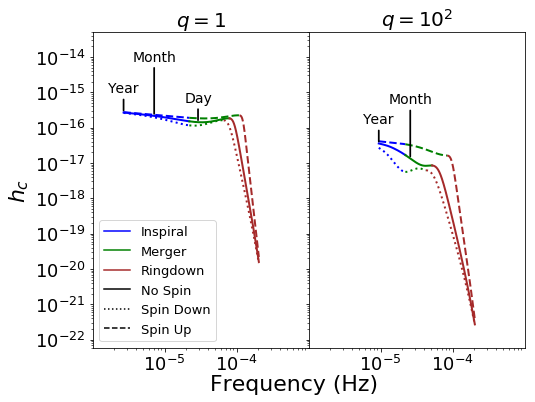

In [75]:
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
fig1.set_size_inches(8,6)
plt.subplots_adjust(wspace=0.0, left=0.15, bottom=0.15)

M = 1e8
z = 1.0
start_time = 1.0
end_time = 0.0
ax1.set_title(r'$q=1$', fontsize=20)
ax2.set_title(r'$q=10^{2}$', fontsize=20)
for q, ax in [[1, ax1], [1/100,ax2]]:
    ax.set_ylim(6e-23, 5e-14)
    ax.set_xlim(1e-6, 1e-3)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(18)
    
    for s, ls in [[-0.8, 'dotted'], [0.0, 'solid'], [0.8,'dashed']]:
        m1 = M/(1+q)
        m2 = M*q/(1+q)
        wave = PhenomDWaveforms(m1, m2, s, s, z, start_time, end_time, num_points=4096)
        wave.create_waveforms()
        
        f = wave.freqs
        hc = wave.amplitude*np.sqrt(96/200) #averaging factor see Cornish and Robson 2018
        
        ins = np.where(f<wave.fmrg)[0]
        mrg = np.where((f>=wave.fmrg)&(f<=wave.fpeak))[0]
        rd = np.where(f>wave.fpeak)[0]
        
        ax.loglog(f[ins], hc[ins], color='blue', ls = ls, lw = 2)
        ax.loglog(f[mrg], hc[mrg], color='green', ls = ls, lw = 2)
        ax.loglog(f[rd], hc[rd], color='brown', ls = ls, lw = 2)
        if s == 0.0:
            N = m1*m2/(m1+m2)**2.
            start_times = np.array([1.0,1.0/12.0, 1.0/365.25,1.0/(365.25*24.0)])*ct.Julian_year/(1+z)

            tau = N*(start_times*ct.c)/(5.*(m1+m2)*Msun*ct.G/(ct.c**2.))
            flow = 1./(8.*ct.pi*(m1+m2)*Msun*ct.G/(ct.c**2.)*tau**(3./8.))*(1.+((11./32)*N+743./2688.)*tau**(-1./4.))*ct.c/(1+z)

            print(f, flow)
            try:
                f_1y_ind = np.where(f >= flow[0])[0][0]
            except IndexError:
                f_1y_ind = 0
            ax.annotate("Year",xy=(f[f_1y_ind], hc[f_1y_ind]), xycoords='data',xytext=(0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)  
            
            f_1m_ind = np.where(f >= flow[1])[0][0]
            ax.annotate("Month",xy=(f[f_1m_ind], hc[f_1m_ind]), xycoords='data',xytext=(0.0, 55), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)
            
            if q != 1/100:
                f_1d_ind = np.where(f >= flow[2])[0][0]
                ax.annotate("Day",xy=(f[f_1d_ind], hc[f_1d_ind]), xycoords='data',xytext=(0.0, 20), ha='center', textcoords='offset points',arrowprops=dict(arrowstyle="-",linewidth = 1.75), fontsize=14)

ax1.plot(1,1, color='blue', ls='solid', label='Inspiral')
ax1.plot(1,1, color='green', ls='solid', label='Merger')
ax1.plot(1,1, color='brown', ls='solid', label='Ringdown')
ax1.plot(1,1, color='black', ls='solid', label='No Spin')
ax1.plot(1,1, color='black', ls='dotted', label='Spin Down')
ax1.plot(1,1, color='black', ls='dashed', label='Spin Up')
ax1.legend(loc='lower left', prop={'size':13})
ax1.set_ylabel(r'$h_c$', fontsize = 22)
ax1.set_xticks([1e-5, 1e-4])

fig1.text(0.5, 0.05, 'Frequency (Hz)', ha = 'center', fontsize=22)
#fig1.savefig('figures/Phase_tracks1.pdf', dpi=250)

## Sensitivity Curves Used

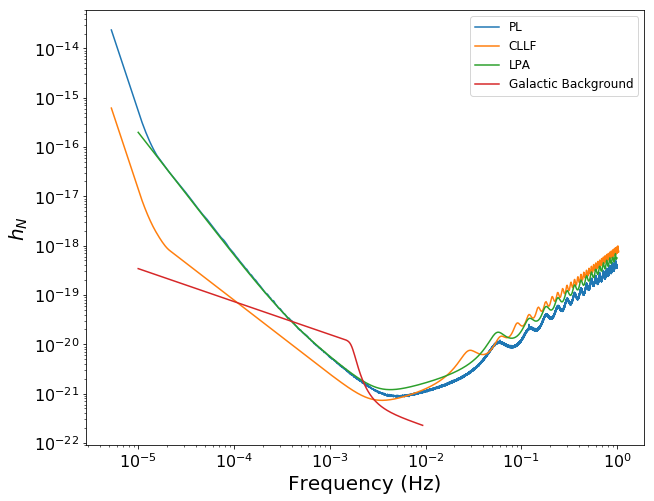

In [76]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(10,8)

for nc in ['PL', 'CLLF', 'LPA', 'WDnoise']:
    fn, hn = read_noise_curve(nc, noise_type='characteristic_strain')
    if nc == 'WDnoise':
        nc = 'Galactic Background'
    ax.loglog(fn, hn, label=nc)
    
ax.tick_params(labelsize=16)
ax.set_xlabel('Frequency (Hz)', fontsize=20)
ax.set_ylabel(r'$h_N$', fontsize=20)
ax.legend(prop={'size':12})
#fig.savefig('figures/sensitivity_curves.pdf', dpi=250)

## Initial Histograms

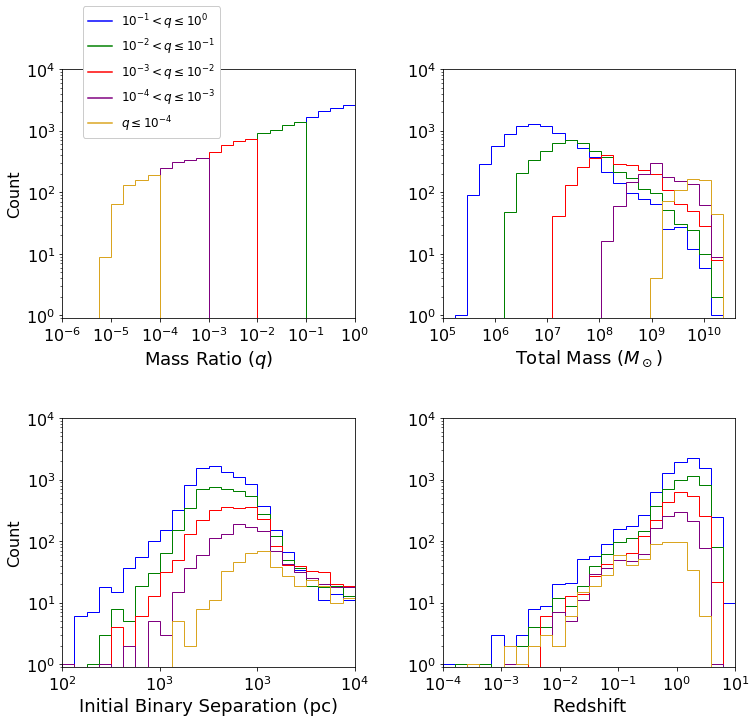

In [77]:
data = np.genfromtxt('simulation_input_data.txt', names=True)

m1 = data['mass_new_prev_in']
m2 = data['mass_new_prev_out']

separation = data['separation']*1e3

redshift = data['redshift']

total_mass = m1+m2

q = mass_ratio_func(m1, m2)

inds_set = []
for i in np.arange(1,5):
    inds_set.append(np.where((q<=10.0**-(i-1)) & (q>10.0**-(i)))[0])

inds_set.append(np.where((q<10.0**-(4)))[0])

total_num = len(total_mass)

fig, ax = plt.subplots(nrows=2, ncols=2)
ax = ax.ravel()
fig.set_size_inches(11,11)
xlims = [[-6,0],[5,10.6],[2.5,4],[-4.0,1.0]]
colors = ['blue', 'green', 'red', 'purple', 'goldenrod']

w = 0
for parameter in [q, total_mass, separation, redshift]:
    ww = 0
    for inds in inds_set:
        #weights = np.ones_like(parameter[inds])/float(len(parameter))
        #ax[w].hist(np.log10(parameter[inds]), bins=num_bins[w], histtype = 'step', weights=weights, log=True)

        bins = np.linspace(xlims[w][0], xlims[w][1], 25)
        try:
            ax[w].hist(np.log10(parameter[inds]), bins=bins, histtype = 'step', log=True, color = colors[ww])
        except IndexError:
            pdb.set_trace()
        ww+=1
        
    ax[w].set_ylim(9e-1, 1e4)
    ax[w].set_xlim(xlims[w])


    w+=1

#legend
legend_ind = 0
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[0], label = r'$10^{-1}<q\leq 10^0$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[1], label = r'$10^{-2}<q\leq 10^{-1}$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[2], label = r'$10^{-3}<q\leq 10^{-2}$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[3], label = r'$10^{-4}< q\leq 10^{-3}$')
ax[legend_ind].plot([-100,-100], [-220, 200], color = colors[4], label = r'$q\leq 10^{-4}$')

xtickfontsize = 16
xlabelfontsize = 18

#ax[0].legend(bbox_to_anchor=(3.0, 0.05), prop={'size':11})
legend = ax[0].legend(bbox_to_anchor=[0.05, 0.7],ncol=1, prop={'size':12}, fancybox=True, framealpha=1.0)
#legend = ax[1].legend(bbox_to_anchor=[1.2, 0.0], prop={'size':10.5}, ncol=1, fancybox=True, framealpha=1.0)


#labels
ax[0].set_xlabel(r'Mass Ratio ($q$)', fontsize=xlabelfontsize)
ax0_xticks = [-6.0,-5.0, -4.0, -3.0, -2.0, -1.0, 0.0]
ax[0].set_xticks(ax0_xticks)
ax[0].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax0_xticks], fontsize=xtickfontsize)

ax[1].set_xlabel(r'Total Mass ($M_\odot$)', fontsize=xlabelfontsize)
ax1_xticks = [5.0, 6.0,7.0, 8.0, 9.0, 10.0]
ax[1].set_xticks(ax1_xticks)
ax[1].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax1_xticks], fontsize=xtickfontsize)

ax[2].set_xlabel('Initial Binary Separation (pc)', fontsize=xlabelfontsize)
ax2_xticks = [2.5, 3.0,3.5, 4.0]
ax[2].set_xticks(ax2_xticks)
ax[2].set_xticklabels([r'$10^{%.1g}$'%int(i) for i in ax2_xticks], fontsize=xtickfontsize)

ax[3].set_xlabel('Redshift', fontsize=xlabelfontsize)
ax3_xticks = [-4.0, -3.0, -2.0, -1.0, 0.0, 1.0]
ax[3].set_xticks(ax3_xticks)
ax[3].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax3_xticks], fontsize=xtickfontsize)

yticks = np.linspace(0.0,4.0, 5)

for w in range(4):
    ax[w].set_yticks(10**yticks)
    ax[w].set_yticklabels([r'$10^{%i}$'%int(i) for i in yticks], fontsize=16)

ax[0].set_ylabel('Count', fontsize=16)
ax[2].set_ylabel('Count', fontsize=16)
plt.subplots_adjust(left = 0.1, right=0.95, hspace=0.4, wspace = 0.3)
#plt.savefig('figures/initial_parameter_hists.pdf', dpi = 300)

## Timescale Histograms

### Choice 1

In [ ]:
data = np.genfromtxt('simulation_input_data.txt', names=True)

evolution_classes = [[EvolveFDFA, {'m1':'mass_new_prev_in', 'm2':'mass_new_prev_out', 
                    'z':'redshift', 'separation':'separation', 'gamma':'star_gamma', 
                    'vel_disp_1':'vel_disp_prev_in',  'vel_disp_2':'vel_disp_prev_out'}, 'FDFA'],
                    [ConstantTime, {'z':'redshift'}, 'Constant']]


q = mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])

inds_set = []
for i in np.arange(1,5):
    inds_set.append(np.where((q<=10.0**-(i-1)) & (q>10.0**-(i)))[0])

inds_set.append(np.where((q<10.0**-(4)))[0])
                     
fig, ax = plt.subplots(nrows=len(evolution_classes), ncols=1, sharex=True, sharey=True)
ax = ax.ravel()
#ax = [ax]

fig.set_size_inches(9,7)
xlims = [[8.,11.]]
colors = ['blue', 'green', 'red', 'purple', 'goldenrod']

w = 0
bins = np.linspace(xlims[w][0], xlims[w][1], 25)
for evolve_class, evolve_dict, label in evolution_classes:
    evolve_kwargs = {key:data[evolve_dict[key]] for key in evolve_dict.keys()}
    evolve = evolve_class(**evolve_kwargs)
    evolve.evolve()
    ww = 0
    for inds in inds_set:
        ax[w].hist(np.log10(evolve.t_delay[inds]), bins=bins, histtype = 'step', log=True, color = colors[ww])
        ww+=1

    ax[w].set_ylim(9e-1, 1e4)
    ax[w].set_xlim(xlims[0])
    w+=1



#legend
ax[0].plot([-100,-100], [-220, 200], color = colors[0], label = r'$10^{-1}<q\leq 10^0$')
ax[0].plot([-100,-100], [-220, 200], color = colors[1], label = r'$10^{-2}<q\leq 10^{-1}$')
ax[0].plot([-100,-100], [-220, 200], color = colors[2], label = r'$10^{-3}<q\leq 10^{-2}$')
ax[0].plot([-100,-100], [-220, 200], color = colors[3], label = r'$10^{-4}< q\leq 10^{-3}$')
ax[0].plot([-100,-100], [-220, 200], color = colors[4], label = r'$q\leq 10^{-4}$')

#ax[0].legend(bbox_to_anchor=(3.0, 0.05), prop={'size':11})
legend = ax[0].legend(bbox_to_anchor=(0.65, 0.65), ncol=1, prop={'size':13}, fancybox=True, framealpha=1.0)
#labels
ax[-1].set_xlabel('Binary Coalescence Timescale (Years)', fontsize=18)
fig.text(0.02, 0.5, "Count", rotation='vertical', fontsize=18)

ax0_xticks = [8.0, 9., 10., 11.]
yticks = np.linspace(1.0,4.0, 4)
tickfontsize = 16
for w in range(len(evolution_classes)):
    ax[w].set_xticks(ax0_xticks)
    ax[w].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax0_xticks], fontsize=tickfontsize)
    ax[w].set_yticks(10**yticks)
    ax[w].set_yticklabels([r'$10^{%i}$'%int(i) for i in yticks], fontsize=tickfontsize)

plt.subplots_adjust(left = 0.1, right=0.95, hspace=0.0, wspace = 0.3)
fig.savefig('figures/merger_timescales.pdf', dpi=300)

### Choice 2

In [ ]:
data = np.genfromtxt('simulation_input_data.txt', names=True)

evolution_classes = [[EvolveFDFA, {'m1':'mass_new_prev_in', 'm2':'mass_new_prev_out', 
                    'z':'redshift', 'separation':'separation', 'gamma':'star_gamma', 
                    'vel_disp_1':'vel_disp_prev_in',  'vel_disp_2':'vel_disp_prev_out'}, 'FDFA'], 
                     [ConstantTime, {'z':'redshift'}, 'Constant']]


fig, ax = plt.subplots(nrows=1, ncols=1)

fig.set_size_inches(9,7)
xlims = [[8.,11.]]
colors = ['blue', 'green', 'red', 'purple', 'goldenrod']
bins = np.linspace(xlims[0][0], xlims[0][1], 25)
w = 0
for evolve_class, evolve_dict, label in evolution_classes:
    evolve_kwargs = {key:data[evolve_dict[key]] for key in evolve_dict.keys()}
    evolve = evolve_class(**evolve_kwargs)
    evolve.evolve()
    ax.hist(np.log10(evolve.t_delay), bins=bins, histtype = 'step', log=True, color = colors[w], label=label)
    
    w+=1

#ax[0].legend(bbox_to_anchor=(3.0, 0.05), prop={'size':11})
legend = ax.legend(loc='upper right', prop={'size':13}, fancybox=True, framealpha=1.0)
#labels
ax.set_xlabel('Binary Coalescence Timescale (Years)', fontsize=18)
fig.text(0.02, 0.5, "Count", rotation='vertical', fontsize=18)

ax.set_ylim(9e-1, 1e4)
ax.set_xlim(xlims[0])
ax0_xticks = [8.0, 9., 10., 11.]
yticks = np.linspace(0.0,5.0, 6)
tickfontsize = 16
for w in range(len(evolution_classes)):
    ax.set_xticks(ax0_xticks)
    ax.set_xticklabels([r'$10^{%i}$'%int(i) for i in ax0_xticks], fontsize=tickfontsize)
    ax.set_yticks(10**yticks)
    ax.set_yticklabels([r'$10^{%i}$'%int(i) for i in yticks], fontsize=tickfontsize)

plt.subplots_adjust(left = 0.1, right=0.95, hspace=0.4, wspace = 0.3)
fig.savefig('figures/merger_timescales_2.pdf', dpi=300)

## Choice 3

In [ ]:
data = np.genfromtxt('simulation_input_data.txt', names=True)

evolution_classes = [EvolveFDFA, {'m1':'mass_new_prev_in', 'm2':'mass_new_prev_out', 
                    'z':'redshift', 'separation':'separation', 'star_gamma':'star_gamma', 
                    'vel_disp_1':'vel_disp_prev_in',  'vel_disp_2':'vel_disp_prev_out'}, 'FDFA']

q = mass_ratio_func(data['mass_new_prev_in'], data['mass_new_prev_out'])
inds_set = []
for i in np.arange(1,5):
    inds_set.append(np.where((q<=10.0**-(i-1)) & (q>10.0**-(i)))[0])

inds_set.append(np.where((q<10.0**-(4)))[0])
                     
fig, ax = plt.subplots(nrows=4, ncols=1)#, sharex=True, sharey=True)
ax = ax.ravel()
#ax = [ax]

fig.set_size_inches(9,12)
xlims = [[2.,11.]]
colors = ['blue', 'green', 'red', 'purple', 'goldenrod']

w = 0
bins = np.linspace(xlims[w][0], xlims[w][1], 25)
evolve_class, evolve_dict, label = evolution_classes
evolve_kwargs = {key:data[evolve_dict[key]] for key in evolve_dict.keys()}
evolve = evolve_class(**evolve_kwargs)
evolve.evolve()

plot_quantites = ['t_delay', 'large_scale_decay_time', 'DF_timescale', 'Hardening_GW_timescale']


for w, pq in enumerate(plot_quantites):
    ww = 0
    for inds in inds_set:
        if ww>2 and pq=='Hardening_GW_timescale':
            ww+=1
            continue
        ax[w].hist(np.log10(getattr(evolve,pq)[inds]), bins=bins, histtype = 'step', log=True, color = colors[ww])
        ww+=1

    ax[w].set_ylim(6e-1, 1e4)
    ax[w].set_xlim(xlims[0])


#legend
ax[0].plot([-100,-100], [-220, 200], color = colors[0], label = r'$10^{-1}<q\leq 10^0$')
ax[0].plot([-100,-100], [-220, 200], color = colors[1], label = r'$10^{-2}<q\leq 10^{-1}$')
ax[0].plot([-100,-100], [-220, 200], color = colors[2], label = r'$10^{-3}<q\leq 10^{-2}$')
ax[0].plot([-100,-100], [-220, 200], color = colors[3], label = r'$10^{-4}< q\leq 10^{-3}$')
ax[0].plot([-100,-100], [-220, 200], color = colors[4], label = r'$q\leq 10^{-4}$')

#ax[0].legend(bbox_to_anchor=(3.0, 0.05), prop={'size':11})
legend = ax[0].legend(bbox_to_anchor=(0.1, 0.45), ncol=1, prop={'size':13}, fancybox=True, framealpha=1.0)
#labels
ax[-1].set_xlabel('Binary Coalescence Timescale (Years)', fontsize=18)
fig.text(0.01, 0.5, "Count", rotation='vertical', fontsize=20)

ax0_xticks = np.arange(2,12)
yticks = np.array([1, 2, 3])
tickfontsize = 16
labels = ['Total Timescale (Yr)', 'Large Scale Decay Timescale (Yr)', 'Dynamical Friction Timescale (Yr)', 'Hardening Timescale (Yr)']
for w in range(4):
    ax[w].set_xlabel(labels[w], fontsize=18)
    ax[w].set_xticks(ax0_xticks)
    ax[w].set_xticklabels([r'$10^{%i}$'%int(i) for i in ax0_xticks], fontsize=tickfontsize)
    ax[w].set_yticks(10**yticks)
    ax[w].set_yticklabels([r'$10^{%i}$'%int(i) for i in yticks], fontsize=tickfontsize)

plt.subplots_adjust(left = 0.1,right=0.95, hspace=0.5, wspace = 0.3)
fig.savefig('figures/FDFA_evolution_hists.pdf', dpi=300)

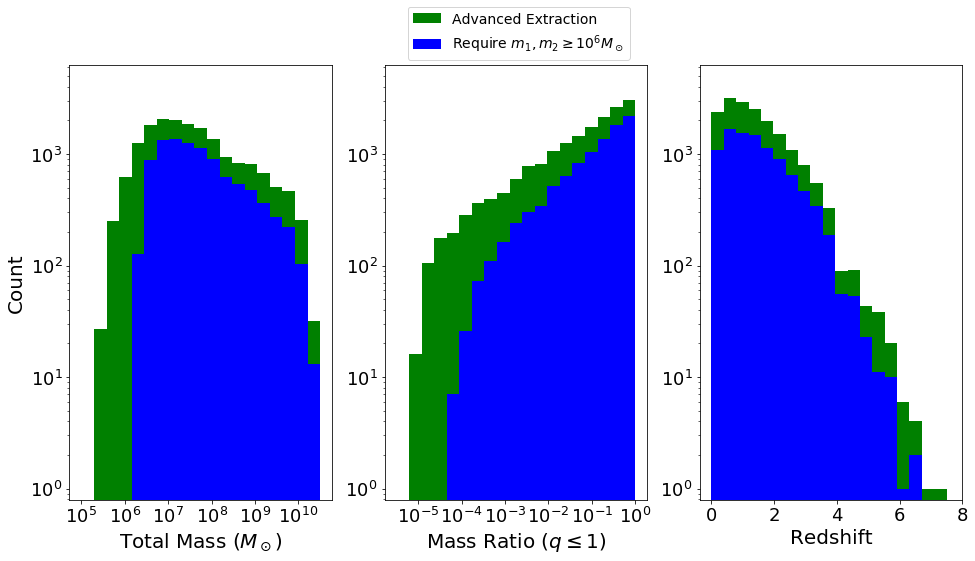

In [78]:
data = np.genfromtxt('simulation_input_data.txt', names=True)
bins_mT = np.linspace(5.0, 10.5, 20)
bins_mr = np.linspace(-5.5, 0.0, 20)
bins_red = np.linspace(0.0, 7.5, 20)
bins, bins1 = np.meshgrid(bins_mT, bins_mr)
mr = data['mass_new_prev_in']/data['mass_new_prev_out']*(data['mass_new_prev_in']<=data['mass_new_prev_out']) + data['mass_new_prev_out']/data['mass_new_prev_in']*(data['mass_new_prev_in']>data['mass_new_prev_out'])
mT = data['mass_new_fin_out']
inds = np.where((data['mass_new_prev_in']>=1e6) & (data['mass_new_prev_out']>=1e6))

y_vals = [10**(-0.1), 10**3.8]
y_ticks = [1e0, 1e1, 1e2, 1e3]
y_ticks_labels = [r'$10^{%i}$'%np.log10(i) for i in y_ticks]
label_fontsize=20
tick_fontsize=18

fig, ax = plt.subplots(1,3)
fig.set_size_inches(16, 8)
ax = ax.ravel()
ax[0].hist(np.log10(mT), bins=bins_mT, log=True, color='green')
ax[0].hist(np.log10(mT[inds]), bins=bins_mT, log=True, color='blue')
ax[0].set_xlabel(r'Total Mass ($M_\odot$)', fontsize=label_fontsize)
xticks = [5, 6, 7, 8, 9, 10]
ax[0].set_xticks(xticks)
ax[0].set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tick_fontsize)


ax[1].hist(np.log10(mr), bins=bins_mr, log=True, color='green', label='Advanced Extraction')
ax[1].hist(np.log10(mr[inds]), bins=bins_mr, log=True, color='blue', label=r'Require $m_1,m_2\geq10^6M_\odot$')
ax[1].set_xlabel(r'Mass Ratio ($q\leq1$)', fontsize=label_fontsize)
xticks = [-5, -4, -3, -2, -1, 0]
ax[1].set_xticks(xticks)
ax[1].set_xticklabels([r'$10^{%i}$'%i for i in xticks], fontsize=tick_fontsize)

ax[2].hist(data['redshift'], bins=bins_red, log=True, color='green')
ax[2].hist(data['redshift'][inds], bins=bins_red, log=True, color='blue')
ax[2].set_xlabel('Redshift', fontsize=label_fontsize)
xticks = [0,2,4,6,8]
ax[2].set_xticks(xticks)
ax[2].set_xticklabels([r'$%i$'%i for i in xticks], fontsize=tick_fontsize)

for i in range(3):
    ax[i].set_ylim(y_vals)
    ax[i].set_yticks(y_ticks)
    ax[i].set_yticklabels(y_ticks_labels, fontsize=tick_fontsize)

ax[0].set_ylabel('Count', fontsize=label_fontsize)
ax[1].legend(prop={'size':14}, bbox_to_anchor=[0.96, 1.15])
#fig.savefig('figures/Extraction_comparison_hist.pdf')
#fig.savefig('../../../../../Candidacy/Extraction_comparison_hist.pdf')

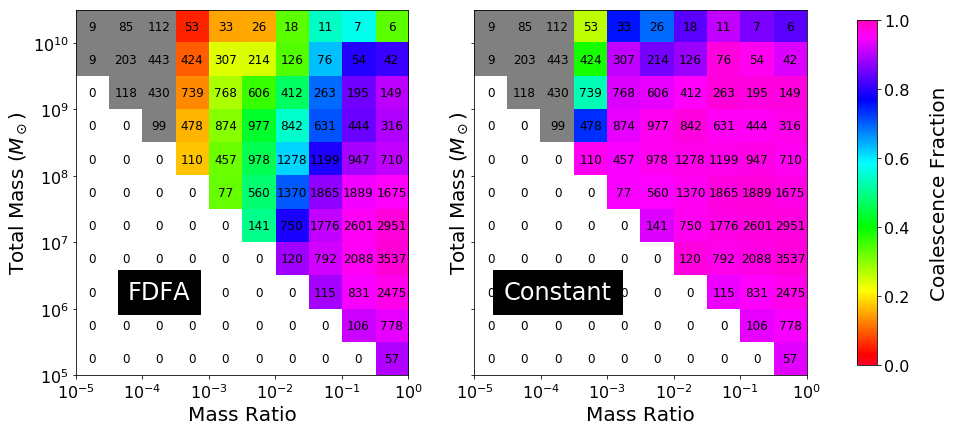

In [176]:
from matplotlib import cm
cmap = cm.gist_rainbow

cmap.set_bad('grey')
cmap.set_under('white')

mt_bins = np.arange(5, 11, 0.5).astype(float)
mr_bins = np.arange(-5, 0.5, 0.5).astype(float)

mt = evolve_out['data']['mt']
mr = evolve_out['data']['mr']

label_fontsize = 20
tick_fontsize = 16

labels = ['FDFA', 'Constant']

fig, ax = plt.subplots(1, len(labels), sharex=True, sharey=True)
fig.set_size_inches(14,8)
cax = fig.add_axes([0.9,0.2,0.02,0.6])
plt.subplots_adjust(bottom=0.0, top=1.0, right=0.85)
try:
    ax = ax.ravel()
except AttributeError:
    ax = [ax]

binned_coal_frac = np.zeros((len(mt_bins)-1, len(mr_bins)-1))
binned_life_mean = np.zeros_like(binned_coal_frac)
check_mr = np.zeros_like(binned_coal_frac)
check_mt = np.zeros_like(binned_coal_frac)
keep_vals = np.zeros_like(binned_coal_frac, dtype=int)
for num, label in enumerate(labels):
    t_coal = evolve_out[label]['timescale']
    coal_bool = evolve_out[label]['coalesced']
    for i,mt_exp in enumerate(mt_bins[:-1]):
        for j,mr_exp in enumerate(mr_bins[:-1]):
            keep = (mt>=10**mt_exp) & (mt<10**(mt_exp+1)) & (mr>=10**(mr_exp-1)) & (mr<10**mr_exp)
            if np.sum(keep) == 0:
                binned_coal_frac[i][j] = -1.0
                binned_life_mean[i][j] = -1.0
                keep_vals[i][j] = 0
            
            else:
                binned_coal_frac[i][j] = np.sum(coal_bool[keep])/len(coal_bool[keep])
                binned_life_mean[i][j] = np.mean(np.log10(t_coal[keep]))
                keep_vals[i][j] = np.sum(keep)
                
            check_mr[i][j] = 10**mr_exp
            check_mt[i][j] = 10**mt_exp
    
    binned_coal_frac = np.ma.masked_where(binned_coal_frac == 0.0, binned_coal_frac)
    im = ax[num].imshow(binned_coal_frac, cmap=cmap, vmin=0.0, vmax=1.0)
    ax[num].set_xticks(np.arange(-1, len(mr_bins),2)+0.5)
    ax[num].set_xticklabels([r'$10^{%i}$'%i for i in np.arange(-5,1)], fontsize=tick_fontsize)
    ax[num].set_yticks(np.arange(0, len(mt_bins), 2)-0.5)
    ax[num].set_yticklabels([r'$10^{%i}$'%i for i in np.arange(5,11)], fontsize=tick_fontsize)
    ax[num].set_xlim(-0.5, len(mr_bins)-1.5)
    ax[num].set_ylim(-0.5, len(mt_bins)-1.5)
    
    ax[num].set_xlabel(r'Mass Ratio', fontsize=label_fontsize)
    ax[num].set_ylabel(r'Total Mass ($M_\odot$)', fontsize=label_fontsize)

    for i in range(len(mt_bins)-1):
        for j in range(len(mr_bins)-1):
            ax[num].text(j, i, '%i'%keep_vals[i, j],
                           ha="center", va="center", color="k", fontsize=12)
            
    ax[num].text(2,2, label, ha="center", va="center", color="white", fontsize=24,
                 bbox=dict(facecolor='black', edgecolor='black', pad=10.0))
            
cax = fig.colorbar(im, cax=cax)
cax.set_label('Coalescence Fraction', fontsize=20, labelpad=20)
cax.set_ticks([0,0.2,0.4,0.6,0.8,1])
cax.ax.tick_params(labelsize=16)

In [108]:
mr_bins

array([-6. , -5.5, -5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. ,
       -0.5,  0. ])

In [46]:
len(mt)

17573